# Imports

In [ ]:
import io
import os
import glob
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 

%matplotlib inline

import pickle

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *

import re
from bs4 import BeautifulSoup

import random
import math
import copy

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable

In [ ]:
# DATA = 'europarl'
DATA = 'newscarl'

# Downloading the Data

In [ ]:
if DATA == 'europarl':
  URLS=["http://www.statmt.org/europarl/v10/training-monolingual/europarl-v10.es.tsv.gz"]
elif DATA == 'newscarl':
    URLS=[
    "http://data.statmt.org/news-crawl/es/news.2007.es.shuffled.deduped.gz",
    "http://data.statmt.org/news-crawl/es/news.2008.es.shuffled.deduped.gz",
    "http://data.statmt.org/news-crawl/es/news.2009.es.shuffled.deduped.gz",
    # "http://data.statmt.org/news-crawl/es/news.2010.es.shuffled.deduped.gz",
    # "http://data.statmt.org/news-crawl/es/news.2011.es.shuffled.deduped.gz",
    # "http://data.statmt.org/news-crawl/es/news.2012.es.shuffled.deduped.gz",
    # "http://data.statmt.org/news-crawl/es/news.2013.es.shuffled.deduped.gz",
    # "http://data.statmt.org/news-crawl/es/news.2014.es.shuffled.deduped.gz",
    # "http://data.statmt.org/news-crawl/es/news.2015.es.shuffled.deduped.gz",
    # "http://data.statmt.org/news-crawl/es/news.2016.es.shuffled.deduped.gz",
    # "http://data.statmt.org/news-crawl/es/news.2017.es.shuffled.deduped.gz",
    # "http://data.statmt.org/news-crawl/es/news.2018.es.shuffled.deduped.gz",
    # "http://data.statmt.org/news-crawl/es/news.2019.es.shuffled.deduped.gz"
  ]

for u in URLS:
  print(u)
  !wget $u


http://data.statmt.org/news-crawl/es/news.2007.es.shuffled.deduped.gz
--2020-09-17 15:25:31--  http://data.statmt.org/news-crawl/es/news.2007.es.shuffled.deduped.gz
Resolving data.statmt.org (data.statmt.org)... 129.215.197.184
Connecting to data.statmt.org (data.statmt.org)|129.215.197.184|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2705371 (2.6M) [application/x-gzip]
Saving to: ‘news.2007.es.shuffled.deduped.gz’

news.2007.es.shuffl 100%[===================>]   2.58M  --.-KB/s    in 0.1s    

2020-09-17 15:25:31 (18.0 MB/s) - ‘news.2007.es.shuffled.deduped.gz’ saved [2705371/2705371]

http://data.statmt.org/news-crawl/es/news.2008.es.shuffled.deduped.gz
--2020-09-17 15:25:31--  http://data.statmt.org/news-crawl/es/news.2008.es.shuffled.deduped.gz
Resolving data.statmt.org (data.statmt.org)... 129.215.197.184
Connecting to data.statmt.org (data.statmt.org)|129.215.197.184|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106965569 (1

Unzip

In [ ]:
if DATA == 'europarl':
  FILES = ["europarl-v10.es.tsv.gz"]
elif DATA == 'newscarl':
  FILES=[
    "news.2007.es.shuffled.deduped.gz",
    "news.2008.es.shuffled.deduped.gz",
    "news.2009.es.shuffled.deduped.gz",
    # "news.2010.es.shuffled.deduped.gz",
    # "news.2011.es.shuffled.deduped.gz",
    # "news.2012.es.shuffled.deduped.gz",
    # "news.2013.es.shuffled.deduped.gz",
    # "news.2014.es.shuffled.deduped.gz",
    # "news.2015.es.shuffled.deduped.gz",
    # "news.2016.es.shuffled.deduped.gz",
    # "news.2017.es.shuffled.deduped.gz",
    # "news.2018.es.shuffled.deduped.gz",
    # "news.2019.es.shuffled.deduped.gz"
  ]

for f in FILES:
  print(f)
  !gunzip $f

news.2007.es.shuffled.deduped.gz
news.2008.es.shuffled.deduped.gz
news.2009.es.shuffled.deduped.gz


Join all data

In [ ]:
if DATA == 'europarl':
  CORPORA = ["europarl-v10.es.tsv"]
elif DATA == 'newscarl':
  CORPORA=[
    "news.2007.es.shuffled.deduped",
    "news.2008.es.shuffled.deduped",
    "news.2009.es.shuffled.deduped",
    # "news.2010.es.shuffled.deduped",
    # "news.2011.es.shuffled.deduped",
    # "news.2012.es.shuffled.deduped",
    # "news.2013.es.shuffled.deduped",
    # "news.2014.es.shuffled.deduped",
    # "news.2015.es.shuffled.deduped",
    # "news.2016.es.shuffled.deduped",
    # "news.2017.es.shuffled.deduped",
    # "news.2018.es.shuffled.deduped",
    # "news.2019.es.shuffled.deduped"
  ]

with open('corpus.es', 'w') as outfile:
    for fname in CORPORA:
        print('Joining file:', fname)
        with open(fname) as infile:
            for line in infile:
                outfile.write(line)

Joining file: news.2007.es.shuffled.deduped
Joining file: news.2008.es.shuffled.deduped
Joining file: news.2009.es.shuffled.deduped


Removing extra files

In [ ]:
!rm *.deduped *.tsv
!du -sh corpus.es

425M	corpus.es


Keep reduced file

In [ ]:
MAX_LINES = 10000

with open('corpus.es', 'r') as cfile:
  with open('corpus.reduced.es', 'w') as rfile:
    count = 0
    while count < MAX_LINES:
      line = cfile.readline()
      rfile.write(line)
      count += 1
    print(count)

10000


# Read Data

In [ ]:
FILE = 'corpus.reduced.es'
data = []

with open(FILE, 'r') as corpus_file:
  Lines = corpus_file.readlines()   
  for line in Lines:
    data.append(line)
    

In [ ]:
print(len(data))

10000


# Processing the data

In [ ]:
def sentence_to_words(sentence):
    nltk.download("stopwords", quiet=True)
    stemmer = PorterStemmer()
    
    text = BeautifulSoup(sentence, "html.parser").get_text() # Remove HTML tags
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower()) # Convert to lower case
    words = text.split() # Split string into words
    words = [w for w in words if w not in stopwords.words("spanish")] # Remove stopwords
    words = [PorterStemmer().stem(w) for w in words] # stem
    
    return words

In [ ]:
print(data[50])
print(sentence_to_words(data[50]))


Y este final de año ha venido marcado por dos hitos significativos en el campo de los universos paralelos.

['final', 'venido', 'marcado', 'do', 'hito', 'significativo', 'campo', 'universo', 'paralelo']


Also: Remove all sentences with less than 5 words and more than 35

In [ ]:
import time
MAX_PADDING = 35
MIN_LEN_SENTENCE = 5
preprocessed_data = []
start = time.time()
perc = 0
for ind, s in enumerate(data):
  words = sentence_to_words(s)
  if len(words) >= MIN_LEN_SENTENCE and len(words) <= MAX_PADDING :
    preprocessed_data.append(words)
  if ind > perc:
    print('{}/{} sentences preprocessed'.format(perc, len(data)))
    perc += 1000

end = time.time()
print(end-start)


0/10000 sentences preprocessed
1000/10000 sentences preprocessed
2000/10000 sentences preprocessed
3000/10000 sentences preprocessed
4000/10000 sentences preprocessed
5000/10000 sentences preprocessed
6000/10000 sentences preprocessed
7000/10000 sentences preprocessed
8000/10000 sentences preprocessed
9000/10000 sentences preprocessed
56.64922022819519


In [ ]:
len(preprocessed_data)

8395

In [ ]:
print(preprocessed_data[50])

['all', 'quedo', 'pasto', 'buitr', 'perro', 'vagabundo', 'dem', 's', 'animal', 'carro', 'ero']


# Build Dictionary

In [ ]:
def build_dict(data, vocab_size = 5000):
    """Construct and return a dictionary mapping each of the most frequently appearing words to a unique integer."""
    
    # TODO: Determine how often each word appears in `data`. Note that `data` is a list of sentences and that a
    #       sentence is a list of words.
    word_count = {} # A dict storing the words that appear in the reviews along with how often they occur

    for sentence in data:
        for word in sentence:
            if word in word_count:
                word_count[word]+=1
            else:
                word_count[word]=1
    
    # TODO: Sort the words found in `data` so that sorted_words[0] is the most frequently appearing word and
    #       sorted_words[-1] is the least frequently appearing word.
    
    sorted_words = sorted(word_count.items(), key=lambda x: x[1], reverse=True)
    sorted_words = [tupl[0] for tupl in sorted_words]

    word_dict = {} # This is what we are building, a dictionary that translates words into integers
    for idx, word in enumerate(sorted_words[:vocab_size - 3]): # The -3 is so that we save room for the 'no word'
        word_dict[word] = idx + 3                              # 'infrequent' 'pad' labels
        
    return word_dict, word_count

In [ ]:
SIZE_VOCAB = 5000
word_dict, complete_dict = build_dict(preprocessed_data, SIZE_VOCAB)
list_dict = [key for key in word_dict.keys()]
print(list_dict[:20])

print('Selected {}/{} words'.format(SIZE_VOCAB, len(complete_dict)))

['n', 's', 'm', 'as', 'd', 'est', 'ser', 'espa', 'do', 'tambi', 'si', 'euro', 'l', 'c', 'millon', 'seg', 'ayer', 'p', 'an', 'part']
Selected 5000/20827 words


In [ ]:
# We will add the XXX as 0 in the dictionary, so when a custom sentence is inputted, the XXX will mark the word the model has to guess
word_dict['XXX'] = 0
word_dict['PAD'] = 1
word_dict['INFREQ'] = 2

# Convert and pad data

In [ ]:
def convert_and_pad(word_dict, sentence, pad=500):
    NOWORD = 1 # We will use 0 to represent the 'no word' category
    INFREQ = 2 # and we use 1 to represent the infrequent words, i.e., words not appearing in word_dict
    
    working_sentence = [NOWORD] * pad
    
    for word_index, word in enumerate(sentence[:pad]):
      if word_index < pad:
        if word in word_dict:
            working_sentence[word_index] = word_dict[word]
        else:
            working_sentence[word_index] = INFREQ
            
    return working_sentence, min(len(sentence), pad)

def convert_and_pad_data(word_dict, data, pad=500):
    result = []
    lengths = []
    
    for sentence in data:
        converted, leng = convert_and_pad(word_dict, sentence, pad)
        result.append(converted)
        lengths.append(leng)
        
    return np.array(result), np.array(lengths)

In [ ]:
int_data, int_data_len = convert_and_pad_data(word_dict, preprocessed_data, MAX_PADDING)

In [ ]:
print(int_data[50], int_data_len[50])


[ 342    2    2    2    2    2  555    4 1896    2  902    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1] 11


# Extract word

In [ ]:
# Check there is no sentence with all 2's
int_data_pre = [d for d, lend in zip(int_data, int_data_len) if len(set(d[:lend])) > 1]
len_data_pre = [lend for d, lend in zip(int_data, int_data_len) if len(set(d[:lend])) > 1]
print('{} of the {} sentences were only 2\'s'.format(len(int_data)-len(int_data_pre), len(int_data)))

2 of the 8395 sentences were only 2's


In [ ]:
start = time.time()
masked_data = []
word_masked = []

masked_data = int_data_pre.copy()

for idx, (sentence, len_sentence) in enumerate(zip(int_data_pre, len_data_pre)):
  acceptable_value = False
  
  while acceptable_value == False:
    idx_word = random.randint(0, len_sentence-1)
    if int_data_pre[idx][idx_word] != 2:
      acceptable_value = True
  
  word_masked.append(int_data_pre[idx][idx_word]) #save the word extracted  
  masked_data[idx][idx_word] = 0 #put this word to 0

end = time.time()
print('Run for: {}s'.format(end-start))

Run for: 0.03603315353393555s


In [ ]:
print(int_data_pre[50])
print(masked_data[50])
print(word_masked[50])
search2 = [el for el in word_masked if el == 2]
print(search2)

[ 342    2    2    2    2    2  555    4 1896    2    0    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1]
[ 342    2    2    2    2    2  555    4 1896    2    0    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1]
902
[]


# Split Training, Validation, Test

In [ ]:
from sklearn.model_selection import train_test_split

train_x, valid_x, train_y, valid_y, train_len, valid_len = train_test_split(masked_data, word_masked, len_data_pre, test_size=0.25, random_state=42)
valid_x, test_x, valid_y, test_y, valid_len, test_len = train_test_split(valid_x, valid_y, valid_len, test_size=0.4, random_state=42)

In [ ]:
print('train: ', len(train_x), len(train_y), len(train_len))
print('valid: ', len(valid_x), len(valid_y), len(valid_len))
print('test: ', len(test_x), len(test_y), len(test_len))


train:  6294 6294 6294
valid:  1259 1259 1259
test:  840 840 840


# Cleaning variables

In [ ]:
preprocessed_data = None
list_dict = None
int_data = None
int_data_len = None
len_data_pre = None
int_data_pre = None
masked_data = None
word_masked = None
data = None
Lines = None
complete_dict = None

# TRANSFORMER Model

From https://blog.floydhub.com/the-transformer-in-pytorch/

### Embedding

In [ ]:
class Embedder(nn.Module):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, d_model)
    def forward(self, x):
        return self.embed(x)

### Positional Encoder

In [ ]:
class PositionalEncoder(nn.Module):
    def __init__(self, d_model, max_seq_len = 80):
        super().__init__()
        self.d_model = d_model
        
        # create constant 'pe' matrix with values dependant on 
        # pos and i
        pe = torch.zeros(max_seq_len, d_model)
        for pos in range(max_seq_len):
            for i in range(0, d_model, 2):
                pe[pos, i] = \
                math.sin(pos / (10000 ** ((2 * i)/d_model)))
                pe[pos, i + 1] = \
                math.cos(pos / (10000 ** ((2 * (i + 1))/d_model)))
                
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
 
    
    def forward(self, x):
        # make embeddings relatively larger
        x = x * math.sqrt(self.d_model)
        #add constant to embedding
        seq_len = x.size(1)
        x = x + Variable(self.pe[:,:seq_len], \
        requires_grad=False).cuda()
        return x

### Multihead Attention

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, heads, d_model, dropout = 0.1):
        super().__init__()
        
        self.d_model = d_model
        self.d_k = d_model // heads
        self.h = heads
        
        self.q_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(d_model, d_model)
    
    def forward(self, q, k, v, mask=None):
        
        bs = q.size(0)
        
        # perform linear operation and split into h heads
        
        k = self.k_linear(k).view(bs, -1, self.h, self.d_k)
        q = self.q_linear(q).view(bs, -1, self.h, self.d_k)
        v = self.v_linear(v).view(bs, -1, self.h, self.d_k)
        
        # transpose to get dimensions bs * h * sl * d_model
       
        k = k.transpose(1,2)
        q = q.transpose(1,2)
        v = v.transpose(1,2)

	# calculate attention using function we will define next
        scores = attention(q, k, v, self.d_k, mask, self.dropout)
        
        # concatenate heads and put through final linear layer
        concat = scores.transpose(1,2).contiguous()\
        .view(bs, -1, self.d_model)
        
        output = self.out(concat)
    
        return output

### Attention

In [ ]:
def attention(q, k, v, d_k, mask=None, dropout=None):

  scores = torch.matmul(q, k.transpose(-2, -1)) /  math.sqrt(d_k)

  if mask is not None:
    mask = mask.unsqueeze(1)
    scores = scores.masked_fill(mask == 0, -1e9)
    scores = F.softmax(scores, dim=-1)
    
  if dropout is not None:
    scores = dropout(scores)
  
  output = torch.matmul(scores, v)
  return output

### Final Feed Forward

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=2048, dropout = 0.1):
        super().__init__() 
        # We set d_ff as a default to 2048
        self.linear_1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model)
    def forward(self, x):
        x = self.dropout(F.relu(self.linear_1(x)))
        x = self.linear_2(x)
        return x

### Normalization

In [ ]:
class Norm(nn.Module):
    def __init__(self, d_model, eps = 1e-6):
        super().__init__()
    
        self.size = d_model
        # create two learnable parameters to calibrate normalisation
        self.alpha = nn.Parameter(torch.ones(self.size))
        self.bias = nn.Parameter(torch.zeros(self.size))
        self.eps = eps
    def forward(self, x):
        norm = self.alpha * (x - x.mean(dim=-1, keepdim=True)) \
        / (x.std(dim=-1, keepdim=True) + self.eps) + self.bias
        return norm

## Putting all together

In [ ]:
# build an encoder layer with one multi-head attention layer and one # feed-forward layer
class EncoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout = 0.1):
        super().__init__()
        self.norm_1 = Norm(d_model)
        self.norm_2 = Norm(d_model)
        self.attn = MultiHeadAttention(heads, d_model)
        self.ff = FeedForward(d_model)
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)
        
    def forward(self, x, mask):
        x2 = self.norm_1(x)
        x = x + self.dropout_1(self.attn(x2,x2,x2,mask))
        x2 = self.norm_2(x)
        x = x + self.dropout_2(self.ff(x2))
        return x
    
# build a decoder layer with two multi-head attention layers and
# one feed-forward layer
class DecoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout=0.1):
        super().__init__()
        self.norm_1 = Norm(d_model)
        self.norm_2 = Norm(d_model)
        self.norm_3 = Norm(d_model)
        
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)
        self.dropout_3 = nn.Dropout(dropout)
        
        self.attn_1 = MultiHeadAttention(heads, d_model)
        self.attn_2 = MultiHeadAttention(heads, d_model)
        self.ff = FeedForward(d_model).cuda()

    def forward(self, x, e_outputs, src_mask, trg_mask):
          x2 = self.norm_1(x)
          x = x + self.dropout_1(self.attn_1(x2, x2, x2, trg_mask))
          x2 = self.norm_2(x)
          x = x + self.dropout_2(self.attn_2(x2, e_outputs, e_outputs,
          src_mask))
          x2 = self.norm_3(x)
          x = x + self.dropout_3(self.ff(x2))
          return x

# We can then build a convenient cloning function that can generate multiple layers:
def get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

In [ ]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, d_model, N, heads):
        super().__init__()
        self.N = N
        self.embed = Embedder(vocab_size, d_model)
        self.pe = PositionalEncoder(d_model)
        self.layers = get_clones(EncoderLayer(d_model, heads), N)
        self.norm = Norm(d_model)

    def forward(self, src, mask):
        x = self.embed(src)
        x = self.pe(x)
        for i in range(self.N):
            x = self.layers[i](x, mask)
        return self.norm(x)
    
class Decoder(nn.Module):
    def __init__(self, vocab_size, d_model, N, heads):
        super().__init__()
        self.N = N
        self.embed = Embedder(vocab_size, d_model)
        self.pe = PositionalEncoder(d_model)
        self.layers = get_clones(DecoderLayer(d_model, heads), N)
        self.norm = Norm(d_model)

    def forward(self, trg, e_outputs, src_mask, trg_mask):
        x = self.embed(trg)
        x = self.pe(x)
        for i in range(self.N):
            x = self.layers[i](x, e_outputs, src_mask, trg_mask)
        return self.norm(x)

In [ ]:
class Transformer(nn.Module):
    def __init__(self, size_vocab, d_model, N, heads):
        super().__init__()
        self.encoder = Encoder(size_vocab, d_model, N, heads)
        self.decoder = Decoder(size_vocab, d_model, N, heads)
        self.out = nn.Linear(d_model, size_vocab)

    def forward(self, src, trg, src_mask, trg_mask):
        e_outputs = self.encoder(src, src_mask)
        d_output = self.decoder(trg, e_outputs, src_mask, trg_mask)

        output = self.out(d_output)

        return output
# we don't perform softmax on the output as this will be handled 
# automatically by our loss function

## Input Masks

The input mask avoids the possible info by the padding.
The target mask is used to avoid looking at future info when guessing next word.

It uses the complete sentence without the word as an input for the decoder along with the outputs of the decoder.

There are also target masks, when the intention is to not allow the decoder to use future information for the decoding, but in this case we want to use the complete sentence, so there isn't any target mask in this case.

In [ ]:
def create_mask(data, batchsize):
  input_msk = [[[0] if _el == 1 else [1] for _el in _ar] for _ar in data]
  arr_input_msk = np.array(input_msk)

  torch_msk_input = torch.tensor(input_msk).clone()
  mask_sample_ds = torch.utils.data.TensorDataset(torch_msk_input)
  msk_input_loader = torch.utils.data.DataLoader(mask_sample_ds, batch_size=batchsize)

  return msk_input_loader

# Training

In [ ]:
def train(model, train_loader, mask_loader, eval_loader, eval_mask_loader, epochs, optimizer, loss_fn, device):
    print('Start training')
    total_length = len(train_loader.dataset)
    loss_return = []
    eval_loss_return = []

    for epoch in range(1, epochs + 1):
        model.train()
        batchs_done = 0
        total_loss = 0

        for batch, msk_batch in zip(train_loader, mask_loader):
            batch_X, batch_y = batch
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)

            if len(msk_batch)==2:
              input_msk, output_msk = msk_batch
              input_msk = input_msk.to(device)
              output_msk = output_msk.to(device)
            else:
              input_msk = msk_batch[0]
              output_msk = None
              input_msk = input_msk.to(device)

            out = model(batch_X, batch_X, input_msk, output_msk)

            optimizer.zero_grad()

            batch_loss = loss_fn(out[:, -1, :], batch_y)

            batch_loss.backward()
            optimizer.step()

            total_loss += batch_loss.data.item()

        print("Epoch: {}, Loss: {}".format(epoch, total_loss / len(train_loader)))
        loss_return.append(total_loss / len(train_loader))

        if epoch % 5 == 0: #every five epochs an evauation
          eval_total_loss = 0
          model.eval()

          for eval_batch, eval_msk_batch in zip(eval_loader, eval_mask_loader):
            eval_batch_X, eval_batch_y = eval_batch
            eval_batch_X = eval_batch_X.to(device)
            eval_batch_y = eval_batch_y.to(device)

            if len(eval_msk_batch)==2:
              eval_input_msk, eval_output_msk = eval_msk_batch
              eval_input_msk = eval_input_msk.to(device)
              eval_output_msk = eval_output_msk.to(device)
            else:
              eval_input_msk = eval_msk_batch[0]
              eval_output_msk = None
              eval_input_msk = eval_input_msk.to(device)

            eval_out = model(eval_batch_X, eval_batch_X, eval_input_msk, eval_output_msk)

            eval_batch_loss = loss_fn(eval_out[:, -1, :], eval_batch_y)
            eval_total_loss += eval_batch_loss.data.item()

          print("Eval Loss: {}".format(eval_total_loss / len(eval_loader)))
          eval_loss_return.append(eval_total_loss / len(eval_loader))

    return loss_return, eval_loss_return

In [ ]:
# Check all shapes are of 35 check
a = [1 for el in train_x if len(el)!=35]
assert len(a) == 0

In [ ]:
BATCH_SIZE = 128
EPOCHS = 30
LR = 0.001

d_model = 256
heads = 8
N = 6

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

print('Preparing Input Masks')
msk_input_loader = create_mask(train_x, BATCH_SIZE)
valid_msk_input_loader = create_mask(valid_x, BATCH_SIZE)

print('Preparing Train Data Loaders')
train_torch_x = torch.tensor(train_x).clone()
train_torch_y = torch.tensor(train_y).clone()
train_sample_ds = torch.utils.data.TensorDataset(train_torch_x, train_torch_y)
train_loader = torch.utils.data.DataLoader(train_sample_ds, batch_size=BATCH_SIZE)

print('Preparing Validation Data Loaders')
valid_torch_x = torch.tensor(valid_x).clone()
valid_torch_y = torch.tensor(valid_y).clone()
valid_sample_ds = torch.utils.data.TensorDataset(valid_torch_x, valid_torch_y)
valid_loader = torch.utils.data.DataLoader(valid_sample_ds, batch_size=BATCH_SIZE)

print('Initialize Model')
model = Transformer(SIZE_VOCAB, d_model, N, heads).to(device)
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

print('Define Loss and Optimizer')
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR, betas=(0.9, 0.98), eps=1e-9)

mask_sample_ds = None
train_torch_x = None
train_torch_y = None
train_sample_ds = None

print('Going to train')
losses, valid_losses = train(model, train_loader, msk_input_loader, valid_loader, valid_msk_input_loader, EPOCHS, optimizer, loss_function, device)

cuda
Preparing Input Masks
Preparing Train Data Loaders
Preparing Validation Data Loaders
Initialize Model
Define Loss and Optimizer
Going to train
Start training
Epoch: 1, Loss: 7.957170886993408
Epoch: 2, Loss: 7.0784222030639645
Epoch: 3, Loss: 6.996005439758301
Epoch: 4, Loss: 6.946495685577393
Epoch: 5, Loss: 6.963631687164306
Eval Loss: 8.59286584854126
Epoch: 6, Loss: 6.980979862213135
Epoch: 7, Loss: 6.814035568237305
Epoch: 8, Loss: 6.756736421585083
Epoch: 9, Loss: 6.660890922546387
Epoch: 10, Loss: 6.586739377975464
Eval Loss: 9.540335845947265
Epoch: 11, Loss: 6.476794557571411
Epoch: 12, Loss: 6.420280656814575
Epoch: 13, Loss: 6.2891076469421385
Epoch: 14, Loss: 6.2116709804534915
Epoch: 15, Loss: 6.186410675048828
Eval Loss: 10.232352924346923
Epoch: 16, Loss: 6.322247467041016
Epoch: 17, Loss: 6.16582992553711
Epoch: 18, Loss: 5.9779411315917965
Epoch: 19, Loss: 6.052376441955566
Epoch: 20, Loss: 5.98670298576355
Eval Loss: 10.872018718719483
Epoch: 21, Loss: 5.76026908

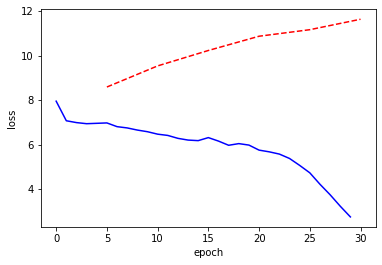

In [ ]:
# We can make a plot to observe better
import matplotlib.pyplot as plt

plt.plot(losses, 'b')
x_axes_val = [i*5+5 for i in range(len(valid_losses))]
plt.plot(x_axes_val, valid_losses, '--r')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Testing

In [ ]:
def evaluate(model, test_loader, masks_loader, loss_fn, batch_size, device):  
  print('Start evaluating')
  total_loss = 0
  model.eval()

  for batch, msk_batch in zip(test_loader, masks_loader):
        batch_X, batch_y = batch
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)

        if len(msk_batch)==2:
          input_msk, output_msk = msk_batch
          input_msk = input_msk.to(device)
          output_msk = output_msk.to(device)
        else:
          input_msk = msk_batch[0]
          output_msk = None
          input_msk = input_msk.to(device)

        len_batch = len(batch_X)

        out = model(batch_X, batch_X, input_msk, output_msk)

        batch_loss = loss_fn(out[:, -1, :], batch_y)
        total_loss += batch_loss.data.item()

  return total_loss / len(train_loader)

In [ ]:
print('Preparing Input Masks')
msk_test_input_loader = create_mask(test_x, BATCH_SIZE)

print('Preparing Data Loaders')
test_torch_x = torch.tensor(test_x).clone()
test_torch_y = torch.tensor(test_y).clone()
test_sample_ds = torch.utils.data.TensorDataset(test_torch_x, test_torch_y)
test_loader = torch.utils.data.DataLoader(test_sample_ds, batch_size=BATCH_SIZE)

test_torch_x = None
test_torch_y = None
test_sample_ds = None

print('Going to test')
test_loss = evaluate(model, test_loader, msk_test_input_loader, loss_function, BATCH_SIZE, device)
print(test_loss)

Preparing Input Masks
Preparing Data Loaders
Going to test
Start evaluating
1.6193408584594726


# Custom Sentence

In [ ]:
def guess_word(custom_sentence):
  # PREPROCESS
  custom_tok = sentence_to_words(custom_sentence)

  # LIMIT LENGTH
  if len(custom_tok) > MAX_PADDING:
    custom_tok = custom_tok[:MAX_PADDING]

  # CONVERT AND PAD
  custom_int, custom_len = convert_and_pad(word_dict, custom_tok, MAX_PADDING)

  # MASK
  msk_input_custom = [[0] if _el == 1 else [1] for _el in custom_int]
  torch_msk_input = torch.tensor(msk_input_custom).clone().unsqueeze(0).to(device)
  output_mask = None


  #PASS THROUGH THE MODEL
  torch_custom = torch.tensor(custom_int).clone().unsqueeze(0).to(device)
  model.eval()
  custom_out = model(torch_custom, torch_custom, torch_msk_input, output_mask)

  custom_out = custom_out[:,-1,:].cpu().detach().numpy().reshape(-1)
  ind_max = np.argmax(custom_out, axis=0)

  for key, value in word_dict.items(): 
    if ind_max == value:
      resulting_word = key
      
  return resulting_word

In [ ]:
test_sentences = [
  "Ha habido una XXX en Colombia durant la presentacion del presidente",
  "Todas las tropas han sido XXX a America",
  "Estaba pensando que quizas XXX deberias hacerlo",
  "Todo lo que llevo esta dentro de mi XXX"
]

for custom_sentence in test_sentences:
  resulting_word = guess_word(custom_sentence)

  print('Initial Sentence: \t {}'.format(custom_sentence))
  print('Word Guessed: \t\t {}'.format(resulting_word))

Initial Sentence: 	 Ha habido una XXX en Colombia durant la presentacion del presidente
Word Guessed: 		 hab
Initial Sentence: 	 Todas las tropas han sido XXX a America
Word Guessed: 		 hab
Initial Sentence: 	 Estaba pensando que quizas XXX deberias hacerlo
Word Guessed: 		 s
Initial Sentence: 	 Todo lo que llevo esta dentro de mi XXX
Word Guessed: 		 n
